# 1. Perkenalan

Halo!

Pada kesempatan kali ini saya akan membuat model classification untuk memprediksi status default pada kartu kredit, dataset yang digunakan adalah `credit_card_default` dari bigquery public data. Dataset berisi informasi tentang usia, gender, tingkat pendidikan dan juga informasi mengenai kartu kredit seperti limit, billing, jumlah pembayaran dan status default dari bulan april sampai september 2005.

# 2. Query SQL

Berikut query yang saya gunakan dengan mengambil beberapa kolom saja dari dataset `credit_card_default`, dan mengubah beberapa tipe data yaitu pada kolom `sex`, `education_level`, `marital_status`, dan `default_payment_next_month` diubah menjadi integer sedangkan pada kolom `pay_5` dan `pay_6` diubah menjadi float. Serta melimit datanya sesuai dengan nomor batch saya dikalikan dengan tahun lahir. Didapat nilai `(20) * (2001) = 40020`

```
SELECT 
limit_balance, 
CAST (sex AS INT64) as sex, 
CAST (education_level AS INT64) as education_level,
CAST (marital_status AS INT64) as marital_status,
age, pay_0, pay_2, pay_3, pay_4, 
CAST (pay_5 AS FLOAT64) as pay_5, 
CAST (pay_6 AS FLOAT64) as pay_6, 
bill_amt_1, bill_amt_2, bill_amt_3, 
bill_amt_4, bill_amt_5, bill_amt_6, pay_amt_1, pay_amt_2, pay_amt_3, 
pay_amt_4, pay_amt_5, pay_amt_6, 
CAST (default_payment_next_month AS INT64) as default_payment_next_month
FROM
`bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 40020
```

# 3. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 

# Evaluation
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve

# Model Saving
import joblib

# 4. Data Loading

In [2]:
# Meload dan menyimpan data file csv kedalam dataframe
data = pd.read_csv('credit_card_default.csv')

In [3]:
# Menampilkan 10 baris teratas pada data
data.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000,1,6,1,54,0,0,0,0,0,...,29296,26210,17643,2545,2208,1336,2232,542,348,1
1,200000,1,4,1,49,0,0,0,0,0,...,50146,50235,48984,1689,2164,2500,3480,2500,3000,0
2,20000,2,6,2,22,0,0,0,0,0,...,1434,500,0,4641,1019,900,0,1500,0,1
3,260000,2,4,2,33,0,0,0,0,0,...,27821,30767,29890,5000,5000,1137,5000,1085,5000,0
4,150000,1,4,2,32,0,0,0,-1,0,...,150464,143375,146411,4019,146896,157436,4600,4709,5600,0
5,300000,2,4,2,32,0,0,0,0,0,...,65150,-450,700,15235,1491,1303,0,2000,1400,0
6,130000,1,1,1,45,0,0,0,0,0,...,62377,63832,65099,2886,2908,2129,2354,2366,2291,0
7,200000,1,1,1,58,0,0,0,0,0,...,124647,126921,129167,7822,4417,4446,4597,4677,4698,0
8,500000,1,1,1,39,0,0,0,0,0,...,174500,137406,204975,54209,4607,4603,5224,207440,7509,0
9,230000,1,1,1,48,0,0,0,0,0,...,105508,108101,110094,7000,6607,3773,4290,4164,2000,0


In [4]:
# Menampilkan 10 baris terbawah pada data
data.tail(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000,2,2,2,26,-1,-1,-1,-1,-2,...,0,0,0,463,2500,0,0,0,0,0
2956,100000,1,3,1,40,0,0,-1,-1,-2,...,0,0,0,2000,2377,40000,0,0,0,0
2957,30000,2,3,1,48,1,-1,-1,-2,-2,...,0,0,0,200,0,0,0,0,0,0
2958,80000,2,3,1,39,-1,-1,-1,-1,-2,...,0,0,5000,5000,5000,0,5000,5000,470,0
2959,20000,1,3,2,26,-1,-1,-1,-2,-2,...,0,0,0,1560,0,0,0,0,0,0
2960,80000,2,3,2,28,-1,-1,-1,-2,-2,...,0,0,0,2800,0,0,0,0,0,0
2961,50000,2,3,1,51,-1,-1,-1,-1,-2,...,0,0,0,300,5880,0,0,0,0,1
2962,450000,2,2,1,38,-2,-2,-2,-2,-2,...,390,390,390,390,780,390,390,390,390,1
2963,50000,2,2,1,44,-2,-2,-2,-2,-2,...,390,390,0,390,390,390,390,0,780,0
2964,290000,2,2,1,39,1,-2,-2,-2,-2,...,3184,390,390,10000,800,3184,390,390,6617,0


In [5]:
# Melihat jumlah baris dan kolom pada data
data.shape

(2965, 24)

In [6]:
# Melihat ringkasan singkat pada data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   limit_balance               2965 non-null   int64
 1   sex                         2965 non-null   int64
 2   education_level             2965 non-null   int64
 3   marital_status              2965 non-null   int64
 4   age                         2965 non-null   int64
 5   pay_0                       2965 non-null   int64
 6   pay_2                       2965 non-null   int64
 7   pay_3                       2965 non-null   int64
 8   pay_4                       2965 non-null   int64
 9   pay_5                       2965 non-null   int64
 10  pay_6                       2965 non-null   int64
 11  bill_amt_1                  2965 non-null   int64
 12  bill_amt_2                  2965 non-null   int64
 13  bill_amt_3                  2965 non-null   int64
 14  bill_amt

Terlihat bahwa dataset berisi 2965 baris dan 24 kolom, serta semua kolom pada data memiliki tipe data integer dan terlihat bahwa nilai non-null yang sama pada seluruh kolom mengindikasikan bahwa tidak adanya null values pada dataset.

Sebelum Melakukan eksplorasi lebih lanjut, Saya ingin mengenali terlebih dahulu masing-masing kolom yang ada dalam dataset. 

Berikut dokumentasi mengenai penjelasan masing-masing kolom:

Columns | Desc
---|---
`limit_balance`|  Amount of given credit in NT dollars (includes individual and family/supplementary credit
`sex` | Gender (1=male, 2=female)
`education_level` | Education Level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
`marital_status` | Marital status (1=married, 2=single, 3=others)
`age` | Age in years
`pay_0` | Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
`pay_2` | Repayment status in August, 2005 (scale same as above)
`pay_3` | Repayment status in July, 2005 (scale same as above)
`pay_4` | Repayment status in June, 2005 (scale same as above)
`pay_5` | Repayment status in May, 2005 (scale same as above)
`pay_6` | Repayment status in April, 2005 (scale same as above)
`bill_amt_1`| Amount of bill statement in September, 2005 (NT dollar)
`bill_amt_2`| Amount of bill statement in August, 2005 (NT dollar)
`bill_amt_3`| Amount of bill statement in July, 2005 (NT dollar)
`bill_amt_4`| Amount of bill statement in June, 2005 (NT dollar)
`bill_amt_5`| Amount of bill statement in May, 2005 (NT dollar)
`bill_amt_6`| Amount of bill statement in April, 2005 (NT dollar)
`pay_amt_1`| Amount of previous payment in September, 2005 (NT dollar)
`pay_amt_2`| Amount of previous payment in August, 2005 (NT dollar)
`pay_amt_3`| Amount of previous payment in July, 2005 (NT dollar)
`pay_amt_4`| Amount of previous payment in June, 2005 (NT dollar)
`pay_amt_5`| Amount of previous payment in May, 2005 (NT dollar)
`pay_amt_6`| Amount of previous payment in April, 2005 (NT dollar)
`default_payment_next_month` | Default payment (1=yes, 0=no)

Dan terakhir, dikarenakan ada beberapa nama kolom yang lumayan panjang pada data, saya akan megubah beberapa nama kolomnya

In [7]:
# Dictionary untuk menyimpan nama kolom yang akan diubah
kolom = {
    'limit_balance': 'limit',
    'education_level' : 'education',
    'marital_status' : 'marriage',
    'default_payment_next_month' : 'default'
}

# Mengubah nama kolomnya
data = data.rename(columns=kolom)

# Menampilkan nama kolom yang sudah diubah
data.columns

Index(['limit', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1', 'bill_amt_2',
       'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1',
       'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6',
       'default'],
      dtype='object')

Dan juga untuk memudahkan, saya akan mengubah angka 1-6 dengan nama bulannya pada kolom pay, bill_amt dan pay_amt

In [8]:
# Dictionary untuk menyimpan nama kolom yang akan diubah
kolom = {
    'pay_0' : 'status_sept',
    'pay_2' : 'status_aug',
    'pay_3' : 'status_july',
    'pay_4' : 'status_june',
    'pay_5' : 'status_may',
    'pay_6' : 'status_apr',

    'bill_amt_1' : 'bill_sept',
    'bill_amt_2' : 'bill_aug',
    'bill_amt_3' : 'bill_july',
    'bill_amt_4' : 'bill_june',
    'bill_amt_5' : 'bill_may',
    'bill_amt_6' : 'bill_apr',

    'pay_amt_1' : 'pay_sept',
    'pay_amt_2' : 'pay_aug',
    'pay_amt_3' : 'pay_july',
    'pay_amt_4' : 'pay_june',
    'pay_amt_5' : 'pay_may',
    'pay_amt_6' : 'pay_apr',
}

# Mengubah nama kolomnya
data = data.rename(columns=kolom)

# Menampilkan nama kolom yang sudah diubah
data.columns

Index(['limit', 'sex', 'education', 'marriage', 'age', 'status_sept',
       'status_aug', 'status_july', 'status_june', 'status_may', 'status_apr',
       'bill_sept', 'bill_aug', 'bill_july', 'bill_june', 'bill_may',
       'bill_apr', 'pay_sept', 'pay_aug', 'pay_july', 'pay_june', 'pay_may',
       'pay_apr', 'default'],
      dtype='object')

# 5. Exploratory Data Analysis (EDA)

Saya tidak terlalu familiar dengan kartu kredit, jadi untuk mendapatkan pemahaman yang lebih mantap, saya akan membahas terlebih dahulu makna dari kolom-kolom yang berkaitan dengan kartu kredit seperti `limit`,`pay` (diubah menjadi status), `bill_amt` (diubah menjadi bill), `pay_amt` (diubah menjadi pay), dan `default`

In [9]:
# Pertama pada kolom limit
data['limit'].unique()

array([ 80000, 200000,  20000, 260000, 150000, 300000, 130000, 500000,
       230000, 460000, 780000, 170000, 320000, 290000, 240000, 340000,
       360000, 380000, 180000, 100000,  90000,  50000, 160000,  70000,
       280000, 220000,  30000, 120000,  10000, 470000, 310000, 140000,
        60000, 110000, 430000, 210000, 490000, 330000, 250000, 400000,
       370000, 440000, 700000, 530000, 390000, 410000, 270000, 560000,
        40000, 680000, 480000, 190000, 350000, 420000, 510000, 800000,
       450000, 750000, 620000], dtype=int64)

Kolom ini memberikan informasi tentang batasan jumlah uang yang bisa dipakai pada kartu kredit dengan mata uang NT dollar atau "New Taiwan Dollars". Nilai NT dollars sama dengan sekitar 480 rupiah (pada waktu notebook ini dibuat)

In [10]:
# Sleanjutnya dikolom pay
data['status_sept'].unique()

array([ 0,  2,  1, -1, -2,  3,  4,  5,  6,  7,  8], dtype=int64)

Sesuai dari penjelasan kolom pada dokumentasi datanya, kolom status ini menunjukkan waktu pembayaran kartu kredit. Value -1 artinya dibayar on time, sedangkan value 1 dibayar telat 1 bulan, value 2 dibayar telat 2 bulan dan seterusnya. 

Namun pada kolom `status_sept` diatas terdapat nilai -2 dan 0 dalam unique valuenya. tidak ada penjelasan mengenai kedua value tersebut pada dokumentasi datasetnya, jadi untuk sekarang saya akan mengasumsikan kalau nilai -2 dibayar lebih cepat dari jatuh tempo pembayaran sedangkan value 0 belum dibayar.

In [11]:
# Setelah itu saya akan melihat pada kolom bill_amt
data['bill_sept'].unique()

array([61454, 49221, 19568, ...,  4280,   752,   -70], dtype=int64)

Bill amount menunjukkan jumlah tagihan atau jumlah uang yang dikeluarkan dengan menggunakan kartu kredit tiap bulannya. Tapi terlihat pada nilai diatas terdapat value bernilai -70. Setelah melakukan riset sedikit, saya menemukan kalau nilai negatif pada bill statement itu artinya bank yang memiliki hutang terhadap kita dan bukan sebaliknya

In [12]:
# Lanjut ke kolom pay_amt
data['pay_sept'].unique()

array([2545, 1689, 4641, ...,  463, 1560,  300], dtype=int64)

pay amount menunjukkan jumlah uang yang dibayar sebelumnya. Menurut saya harusnya kolom pay amount ini akan sangat berkorelasi dengan kolom bill amount dikarenakan pengguna kartu kredit akan mengacu pada bill amount untuk membayar tagihannya 

setelah itu pada kolom `default` dengan memvisualisasikan datanya 

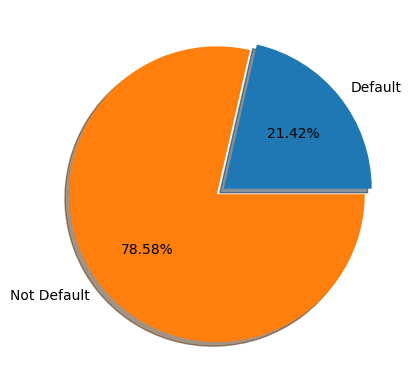

In [13]:
# Membagi data untuk dimasukkan ke 2 variable berbeda
yes = data['default'].value_counts()[1]
no = data['default'].value_counts()[0]

# Konfigurasi untuk Pie Chart
y = np.array([yes,no])
labels = ['Default','Not Default']
explode = [0.06, 0]

# Membuat dan Menampilkan Pie Chart
plt.pie(y, labels=labels, explode=explode, shadow = True, autopct='%.2f%%')
plt.show()

Dan yang terakhir pada kolom yang akan saya jadikan target yaitu pada kolom `default` memiliki value yang berisi 1 artinya default dan 0 artinya not default. Dalam kartu kredit, default itu sendiri adalah ketika pengguna kartu kredit gagal melakukan pembayaran pada kurun waktu tertentu (biasanya 6 bulan) dan penerbit kartu kredit akan menutup akun pengguna tersebut.

Terlihat pada chart diatas, pada dataset terdapat sebanyak 21% yang tergolong default dan 79% not default. Terlihat bahwa proporsi dari datanya termasuk agak imbalance.

Setelah ini saya juga akan melihat beberapa kolom lainnya yang ada pada dataframe 

In [14]:
# Melihat value counts dari kolom education
data['education'].value_counts()

education
2    1400
1    1039
3     483
5      24
4      13
6       4
0       2
Name: count, dtype: int64

Seperti pada dokumentasi resmi datasetnya, "1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown". Terdapat angka 0 pada kolom diatas dan tidak ada penjelasan mengenai angka 0 tersebut di dokumentasinya. Selain itu, terlihat angka 5 dan 6 mempunyai label yang sama yaitu unknown pada dataset. Untuk itu saya akan menggabungkan saja semua data pada 5, 6 dan 0 kedalam 4 (others)

In [15]:
data['education'].replace({0:4, 5:4, 6:4}, inplace=True)

In [16]:
data['education'].value_counts()

education
2    1400
1    1039
3     483
4      43
Name: count, dtype: int64

In [17]:
# Melihat value counts dari kolom marriage
data['marriage'].value_counts()

marriage
2    1594
1    1332
3      35
0       4
Name: count, dtype: int64

Sekali lagi, saya merujuk ke dokumentasi resminya yang mengatakan "1=married, 2=single, 3=others". Namun terlihat pada data diatas bahwa terdapat value bernilai 0 yang tidak terdapat penjelasan pada dokumentasinya. Saya akan melakukan cara yang sama seperti tadi yaitu menggabungkan value 0 ke value 3 (others)

In [18]:
data['marriage'].replace({0:3}, inplace=True)

In [19]:
data['marriage'].value_counts()

marriage
2    1594
1    1332
3      39
Name: count, dtype: int64

In [20]:
# Melihat deskripsi dari kolom age
data['age'].describe()

count    2965.000000
mean       35.193255
std         9.109439
min        21.000000
25%        28.000000
50%        34.000000
75%        41.000000
max        69.000000
Name: age, dtype: float64

Sepertinya pada kolom ini terbilang normal, dapat dilihat bahwa usia pengguna kartu kredit paling rendah berada di usia 21 tahun dan yang tertinggi berada di 69 tahun. dari data deskripsi diatas, saya bisa mengasumsikan bahwa kolom ini mempunyai data yang terdistribusi normal, untuk itu saya akan melihat visualisasi datanya

<Axes: xlabel='age', ylabel='Count'>

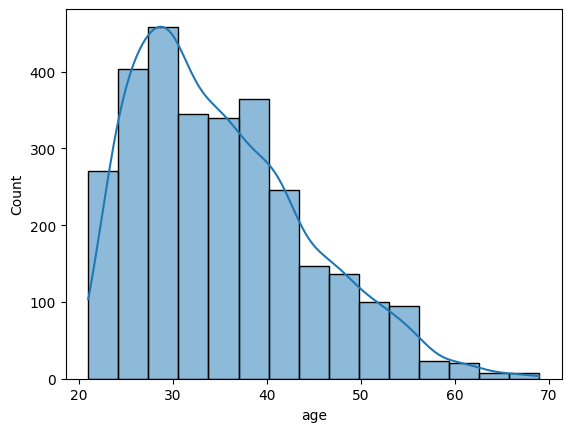

In [21]:
# Melihat distribusi dari kolom age
sns.histplot(data=data, x='age', kde=True, bins=15)

Agak condong ke kiri namun masih bisa terbilang normal, terlihat bahwa usia terbanyak yang menggunakan kartu kredit berada di kisaran usia 30 tahun.

Terakhir saya akan melihat data pada kolom sex

In [22]:
data['sex'].value_counts()

sex
2    1802
1    1163
Name: count, dtype: int64

Merujuk ke dokumentasinya, "1=male, 2=female". Jumlah female sebanyak 1802 orang dan male sebanyak 1163 orang, saya akan visualisasikan datanya dalam bentuk pie chart.

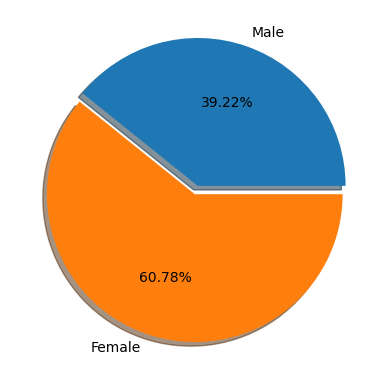

In [23]:
# Terakhir pada kolom `sex`
male = data['sex'].value_counts()[1]
female = data['sex'].value_counts()[2]

# Konfigurasi untuk Pie Chart
y = np.array([male,female])
labels = ['Male','Female']
explode = [0.06, 0]

# Membuat dan Menampilkan Pie Chart
plt.pie(y, labels=labels, explode=explode, shadow = True, autopct='%.2f%%')
plt.show()

Terlihat bahwa jumlah data perempuan lebih banyak ketimbang data lak-laki

Selanjutnya saya akan melihat masing-masing distribusi dari data 6 bulan dari data pay.

<Axes: xlabel='pay_apr', ylabel='Count'>

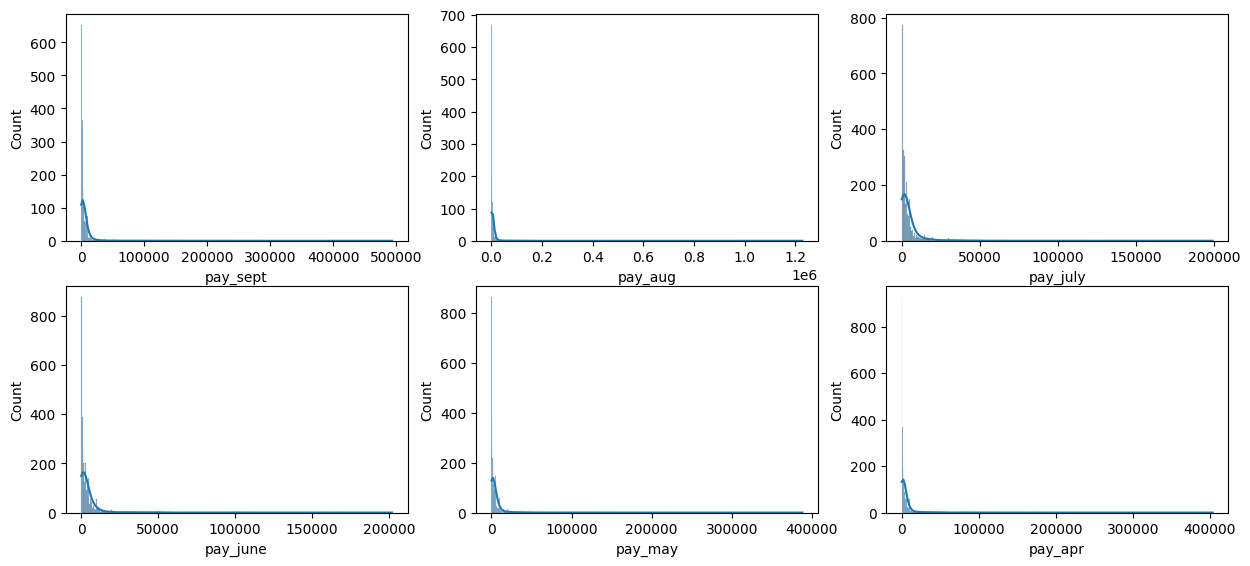

In [24]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 1)
sns.histplot(data['pay_sept'], kde=True)

plt.subplot(3, 3, 2)
sns.histplot(data['pay_aug'], kde=True)

plt.subplot(3, 3, 3)
sns.histplot(data['pay_july'], kde=True)

plt.subplot(3, 3, 4)
sns.histplot(data['pay_june'], kde=True)

plt.subplot(3, 3, 5)
sns.histplot(data['pay_may'], kde=True)

plt.subplot(3, 3, 6)
sns.histplot(data['pay_apr'], kde=True)

Dapat dilihat bahwa data pay diatas memiliki distribusi yang tidak normal dari seluruh bulannya.

dan saya akan melihat pada kolom bill

<Axes: xlabel='bill_apr', ylabel='Count'>

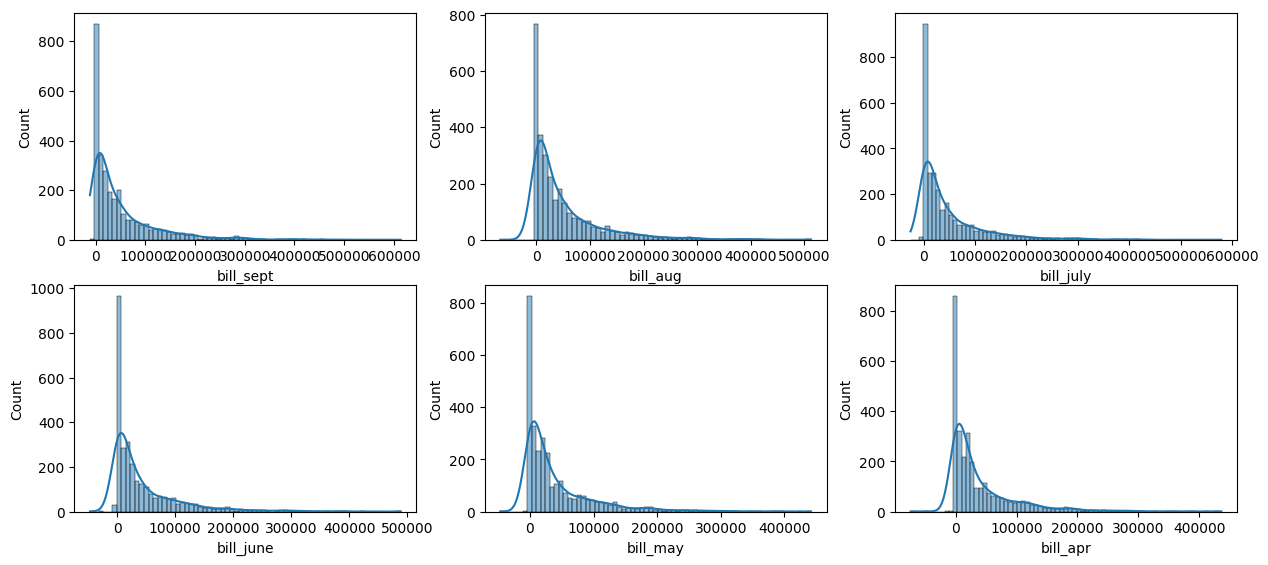

In [25]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 1)
sns.histplot(data['bill_sept'], kde=True)

plt.subplot(3, 3, 2)
sns.histplot(data['bill_aug'], kde=True)

plt.subplot(3, 3, 3)
sns.histplot(data['bill_july'], kde=True)

plt.subplot(3, 3, 4)
sns.histplot(data['bill_june'], kde=True)

plt.subplot(3, 3, 5)
sns.histplot(data['bill_may'], kde=True)

plt.subplot(3, 3, 6)
sns.histplot(data['bill_apr'], kde=True)

Dapat terlihat pada masing-masing kolom bill diatas, distribusinya juga tidak terlihat normal. Menurut saya distribusi yang tidak normal pada kedua jenis kolom bill dan pay ini disebabkan oleh data yang memang luas karakteristiknya, data outlier diatas bisa disebabkan oleh memang ada beberapa orang yang benar-benar memiliki pay dan bill yang sangat tinggi ketimbang kebanyakan orang-orang lainnya

# 6. Feature Engineering

## Splitting Data

In [26]:
# Split data antara X dan y
X = data.drop('default',axis=1)
y = data['default']

# Menampilkan data y
y

0       1
1       0
2       1
3       0
4       0
       ..
2960    0
2961    1
2962    1
2963    0
2964    0
Name: default, Length: 2965, dtype: int64

In [27]:
# Split data untuk dibagi lagi menjadi 4 bagian test dan train
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=15)

# Menampilkan ukuran dari masing-masing train dan test set
print('Ukuran dari Train-Set : ', X_train.shape)
print('Ukuran dari Test-Set  : ', X_test.shape)

Ukuran dari Train-Set :  (2372, 23)
Ukuran dari Test-Set  :  (593, 23)


## Missing Values

In [28]:
# Melihat apakah ada null values pada dataframe
print('Missing Values Train-set :',X_train.isnull().values.any())
print('Missing Values Test-set :',X_test.isnull().values.any())

Missing Values Train-set : False
Missing Values Test-set : False


Tidak ada missing values pada data, Oleh karena itu saya akan langsung melanjutkan ke handling outliers.

## Outliers

Dapat dilihat pada bagian EDA diatas, terdapat outliers yang signifikan pada dataset terutama pada kolom bill dan pay. 

Namun nilai outliers tersebut merupakan nilai murni yang mencerminkan keunikan dari data. Outliers tersebut bukan berasal dari error atau salahnya input data. Melainkan memang ada orang yang benar-benar kaya dan memiliki bill serta pay yang jauh lebih tinggi dari kebanyakan orang lainnya. Oleh karena itu saya akan membiarkan outliers yang ada sebagai Real-world representation dimana dikehidupan nyata memang ada orang-orang tertentu yang memiliki limit, bill, pay yang jauh lebih tinggi dari kebanyakan orang lainnya. Jika saya menghilangkan atau memanipulasi data itu akan menjadikan model yang akan dibuat nanti menjadi tidak akurat ketika memprediksi extreme values yang benar-benar ada di kehidupan nyata.

Singkatnya saya ga akan menghapus atau imputasi ataupun winsorize nilai outliers dikarenakan saya tidak ingin menghilangkan valuable information. Jadi saya akan langsung lanjut ke Feature Scaling

## Feature Scaling

Untuk Scaler yang saya gunakan, saya tidak menggunakan StandardScaler, dikarenakan cara kerja scaler ini mengasumsikan dataset yang terdistribusi normal, dikasus ini data tidak terdistribusi normal dan bisa menyebabkan terjadinya distorsi saat melakukan scaling. Sedangkan MinMaxScaler memang bisa diaplikasikan pada data yang tidak terdistribusi normal namun untuk kasus ini saya menemukan bahwa penggunaan minmaxscaler masih belum optimal dikarenakan tingginya skew pada data. 

Untuk itu, scaler yang akan saya gunakan adalah RobustScaler, Alasannya dikarenakan pada visualisasi EDA diatas dapat dilihat bahwa kebanyakan dari kolom terutama pada kolom pay dan bill memiliki distribusi yang tidak normal atau memiliki outliers yang cukup signifikan. Dengan menggunakan robustscaler, scaler ini akan menskalakan datanya berdasarkan interquantile range antara quartil 1 dan quartil 3. Dengan begitu scaler ini bisa lebih robust terhadap outliers. 

In [29]:
# Menampung fitur yang tergolong numerik kedalam list
numeric_features = [
    'age','limit',
    'status_sept', 'status_aug','status_july','status_june','status_may','status_apr',
    'bill_sept','bill_aug','bill_july','bill_june','bill_may','bill_apr',
    'pay_sept','pay_aug','pay_july','pay_june','pay_may','pay_apr'
    ]

# Membuat Pipeline untuk numerik scaler
numeric_transformer = Pipeline(
    steps=[("scaler", RobustScaler())]
)

## Feature Encoding

Untuk bagian encoding, saya menggunakan OneHotEncoder. Alasannya, pada kolom `sex` dan `marriage` tidak memiliki tingkatan ataupun order. Sebagai contoh pada kolom sex, value male dan female berada pada urutan hirearki yang sama. Sedangkan pada kolom `education` itu memang memiliki tingkatan atau order, namun pada kolom tersebut terdapat value Others. Saya gak bisa menempatkan others ini ke tempat yang lebih rendah dari value yang lain maupun ditempat yang lebih tinggi.

oleh karena itu saya tidak akan menggunakan OrdinalEncoder terhadap kolom tersebut dan untuk mempersimple pengerjaan saya akan menggunakan OneHotEncoder saja terhadap semua kolom kategorik.

In [30]:
# Menampung fitur yang tergolong kategorik kedalam list
categorical_features = ['sex','education','marriage']

# Membuat Pipeline untuk kategorik encoder
categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown='ignore'))]
)

## Merge Columns

Menggabungkan kedua kolom yang akan diencode dan discale tadi menggunakan column transformer

In [31]:
# Membuat Column transformer untuk melakukan scaling dan encoding dan menggabungkan kedua tipe data tersebut
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)],
        remainder = 'passthrough' # Untuk melewatkan selain fitur yg di transform
)

# 7. Model Definition

Pada model definition, saya akan menggunakan baseline model terlebih dahulu pada model-model berikut, Logistic Regression, SVM, Decision Tree, Random Forest, KNN, Naive Bayes. Setelah saya melihat model mana yang paling baik scorenya dalam cross validation saya akan melakukan hyperparameter tuning terhadap model tersebut untuk melihat apakah peforma modelnya masih bisa ditingkatkan.

In [32]:
# Membuat Pipeline untuk Logistic Regression
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor), 
    ('logreg', LogisticRegression())
])

In [33]:
# Membuat Pipeline untuk SVM
pipe_svc = Pipeline([
    ('preprocessor', preprocessor), 
    ('svm', SVC(probability=True))
])

In [34]:
# Membuat Pipeline untuk Decision Tree
pipe_tree = Pipeline([
    ('preprocessor', preprocessor), 
    ('tree', DecisionTreeClassifier())
])

In [35]:
# Membuat Pipeline untuk Random Forest
pipe_forest = Pipeline([
    ('preprocessor', preprocessor), 
    ('forest', RandomForestClassifier())
])

In [36]:
# Membuat Pipeline untuk KNN
pipe_knn = Pipeline([
    ('preprocessor', preprocessor), 
    ('knn', KNeighborsClassifier())
])

In [37]:
# Membuat Pipeline untuk Naive Bayes
pipe_nb = Pipeline([
    ('preprocessor', preprocessor), 
    ('nb', GaussianNB())
])

# 8. Model Training

Disini saya akan fit semua modelnya terhadap X_train dan y_train menggunakan pipeline yang sudah dibuat diatas.

In [38]:
# Train Logistic Regression
pipe_logreg.fit(X_train, y_train)

c:\Users\zidny\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'limit',
                                                   'status_sept', 'status_aug',
                                                   'status_july', 'status_june',
                                                   'status_may', 'status_apr',
                                                   'bill_sept', 'bill_aug',
                                                   'bill_july', 'bill_june',
                                                   'bill_may', 'bill_apr',
                                                   'pay_sept', 'pay_aug',
                                                   'pay_july', 'pay_june',
                                                   'pay_may', 'pay_apr']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'education',
                                                   'marriage'])])),
                ('logreg', LogisticRegression())])

In [39]:
# Train Logistic SVM
pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'limit',
                                                   'status_sept', 'status_aug',
                                                   'status_july', 'status_june',
                                                   'status_may', 'status_apr',
                                                   'bill_sept', 'bill_aug',
                                                   'bill_july', 'bill_june',
                                                   'bill_may', 'bill_apr',
                                                   'pay_sept', 'pay_aug',
                                                   'pay_july', 'pay_june',
                                                   'pay_may', 'pay_apr']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'education',
                                                   'marriage'])])),
                ('svm', SVC(probability=True))])

In [40]:
# Train Decission Tree
pipe_tree.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'limit',
                                                   'status_sept', 'status_aug',
                                                   'status_july', 'status_june',
                                                   'status_may', 'status_apr',
                                                   'bill_sept', 'bill_aug',
                                                   'bill_july', 'bill_june',
                                                   'bill_may', 'bill_apr',
                                                   'pay_sept', 'pay_aug',
                                                   'pay_july', 'pay_june',
                                                   'pay_may', 'pay_apr']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'education',
                                                   'marriage'])])),
                ('tree', DecisionTreeClassifier())])

In [41]:
# Train Random Forest
pipe_forest.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'limit',
                                                   'status_sept', 'status_aug',
                                                   'status_july', 'status_june',
                                                   'status_may', 'status_apr',
                                                   'bill_sept', 'bill_aug',
                                                   'bill_july', 'bill_june',
                                                   'bill_may', 'bill_apr',
                                                   'pay_sept', 'pay_aug',
                                                   'pay_july', 'pay_june',
                                                   'pay_may', 'pay_apr']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'education',
                                                   'marriage'])])),
                ('forest', RandomForestClassifier())])

In [42]:
# Train KNN
pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'limit',
                                                   'status_sept', 'status_aug',
                                                   'status_july', 'status_june',
                                                   'status_may', 'status_apr',
                                                   'bill_sept', 'bill_aug',
                                                   'bill_july', 'bill_june',
                                                   'bill_may', 'bill_apr',
                                                   'pay_sept', 'pay_aug',
                                                   'pay_july', 'pay_june',
                                                   'pay_may', 'pay_apr']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'education',
                                                   'marriage'])])),
                ('knn', KNeighborsClassifier())])

In [43]:
# Train Naive Bayes
pipe_nb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'limit',
                                                   'status_sept', 'status_aug',
                                                   'status_july', 'status_june',
                                                   'status_may', 'status_apr',
                                                   'bill_sept', 'bill_aug',
                                                   'bill_july', 'bill_june',
                                                   'bill_may', 'bill_apr',
                                                   'pay_sept', 'pay_aug',
                                                   'pay_july', 'pay_june',
                                                   'pay_may', 'pay_apr']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'education',
                                                   'marriage'])])),
                ('nb', GaussianNB())])

# 9. Model Evaluation

Pertama saya akan lihat peforma dari keseluruhan model, dengan menggunakan mean cross validation untuk menguji peforma masing-masing modelnya secara objektif dan memperoleh estimasi yang lebih realistis, setelah melihat model mana yang memiliki score tertinggi baru saya akan melihat classification report dari model tersebut terhadap test-set

In [44]:
# Membuat variable untuk menampung KFold
kf = KFold(n_splits=5, shuffle=True)

# Menghitung cross-validation dengan Pipeline
scores_logreg = cross_val_score(pipe_logreg, X, y, cv=kf)
scores_svm = cross_val_score(pipe_svc, X, y, cv=kf)
scores_tree = cross_val_score(pipe_tree, X, y, cv=kf)
scores_forest = cross_val_score(pipe_forest, X, y, cv=kf)
scores_knn = cross_val_score(pipe_knn, X, y, cv=kf)
scores_nb = cross_val_score(pipe_nb, X, y, cv=kf)

c:\Users\zidny\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\zidny\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

In [45]:
# Menampilkan hasil cross validation untuk setiap model
print('Cross-Validation Mean Score :')
print('\nLogistic Regression:', round(scores_logreg.mean(),4),'| std:', round(scores_logreg.std(),4))
print('SVM:', round(scores_svm.mean(),4),'| std:', round(scores_svm.std(),4))
print('Decision Tree:', round(scores_tree.mean(),4),'| std:', round(scores_tree.std(),4))
print('Random Forest:', round(scores_forest.mean(),4),'| std:', round(scores_forest.std(),4))
print('KNN:', round(scores_knn.mean(),4),'| std:', round(scores_knn.std(),4))
print('Naive Bayes:', round(scores_nb.mean(),4),'| std:', round(scores_nb.std(),4))

Cross-Validation Mean Score :

Logistic Regression: 0.8256 | std: 0.0172
SVM: 0.8256 | std: 0.0086
Decision Tree: 0.739 | std: 0.0149
Random Forest: 0.8277 | std: 0.0112
KNN: 0.8175 | std: 0.0202
Naive Bayes: 0.4189 | std: 0.0235


Dapat dilihat diatas pada model yang memiliki peforma teratas adalah Random Forest, logistic regression dan SVM (Ketiga model ini memiliki perbedaan score yang tipis). Namun bisa disimpulkan bahwa Random Forest yang terbaik dikarenakan model ini memiliki score tertinggi dan std terendah menunjukkan konsistensi yang tinggi pada model tersebut.

Selanjutnya saya akan menggunakan Classification Report dan Confusion Matrix sebagai metriks yang akan saya gunakan untuk mengevaluasi peforma model terhadap test set, classification report berisi ringkasan yang lengkap terhadap kinerja model, terdapat metriks seperti precision, recall, f1-score dan accuracy. Saya akan jelaskan keempat metriks ini lebih dalam di conceptual problem pada kesimpulan dibagian bawah notebook. Sedangkan pada confusion matrix, kita bisa melihat seberapa baik model dapat mengklasifikasikan sample-sample kedalam kelas yang benar dan seberapa sering model membuat kesalahan dalam klasifikasi. 

F1 Score - Test Set   :  0.47619047619047616 

Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.95      0.90       472
           1       0.66      0.37      0.48       121

    accuracy                           0.83       593
   macro avg       0.76      0.66      0.69       593
weighted avg       0.82      0.83      0.81       593
 

Confusion Matrix      : 


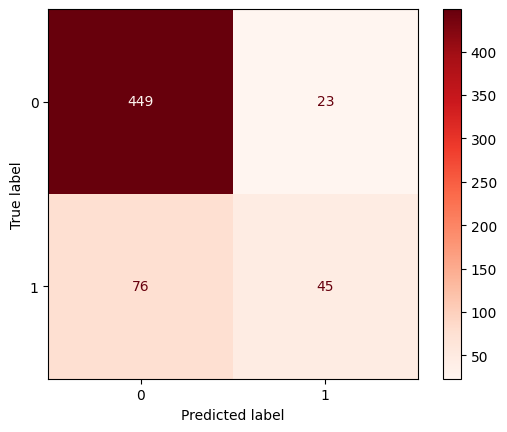

In [46]:
y_pred = pipe_forest.predict(X_test)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(pipe_forest, X_test, y_test, cmap='Reds'))

Dapat dilihat pada model random forest nilai False Negative yang tinggi menunjukkan adanya imbalance pada data. Saya akan mencoba untuk membuat algoritma lain yaitu gradient boosting untuk nantinya dibandingkan apakah algoritma tersebut bisa lebih baik daripada random forest

In [47]:
# Membuat Pipeline untuk Gradient Boosting 
pipe_gradient = Pipeline([
    ('preprocessor', preprocessor), 
    ('logreg', GradientBoostingClassifier())
])

# Train Gradient Boosting
pipe_gradient.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'limit',
                                                   'status_sept', 'status_aug',
                                                   'status_july', 'status_june',
                                                   'status_may', 'status_apr',
                                                   'bill_sept', 'bill_aug',
                                                   'bill_july', 'bill_june',
                                                   'bill_may', 'bill_apr',
                                                   'pay_sept', 'pay_aug',
                                                   'pay_july', 'pay_june',
                                                   'pay_may', 'pay_apr']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'education',
                                                   'marriage'])])),
                ('logreg', GradientBoostingClassifier())])

In [48]:
scores_gradient = cross_val_score(pipe_gradient, X, y, cv=kf)
print('Gradient Boosting:', round(scores_gradient.mean(),4),'| std:', round(scores_gradient.std(),4))

Gradient Boosting: 0.8327 | std: 0.0173


Dapat dilihat pada gradient boosting memiliki mean cross validation yang lebih tinggi daripada random forest walaupun perbedaan dalam cross validationnya hanya sedikit bertambah namun pada model ini memiliki standard deviation kecil, menunjukkan konsistensi pada model jika dibandingkan keenam baseline model tadi.

Saya akan melihat ROC-AUC scorenya juga pada 6 model tadi dan ditambah gradient boosting.

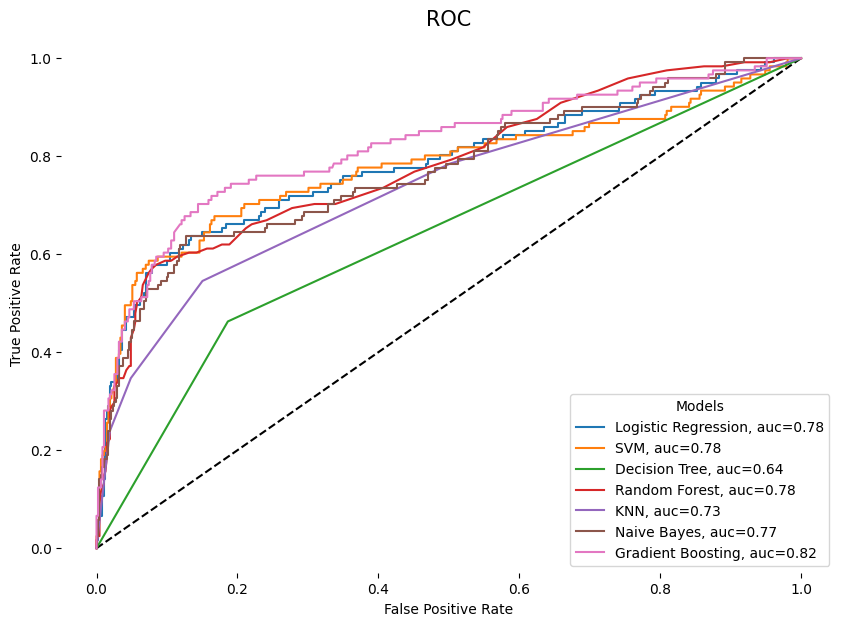

In [49]:
y_pred_proba_lr = pipe_logreg.predict_proba(X_test)[::,1]
fpr1, tpr1, _ = roc_curve(y_test,  y_pred_proba_lr)
auc1 = roc_auc_score(y_test, y_pred_proba_lr)

y_pred_proba_svc = pipe_svc.predict_proba(X_test)[::,1]
fpr2, tpr2, _ = roc_curve(y_test,  y_pred_proba_svc)
auc2 = roc_auc_score(y_test, y_pred_proba_svc)

y_pred_proba_tree = pipe_tree.predict_proba(X_test)[::,1]
fpr3, tpr3, _ = roc_curve(y_test,  y_pred_proba_tree)
auc3 = roc_auc_score(y_test, y_pred_proba_tree)

y_pred_proba_forest = pipe_forest.predict_proba(X_test)[::,1]
fpr4, tpr4, _ = roc_curve(y_test,  y_pred_proba_forest)
auc4 = roc_auc_score(y_test, y_pred_proba_forest)

y_pred_proba_knn = pipe_knn.predict_proba(X_test)[::,1]
fpr5, tpr5, _ = roc_curve(y_test,  y_pred_proba_knn)
auc5 = roc_auc_score(y_test, y_pred_proba_knn)

y_pred_proba_nb = pipe_nb.predict_proba(X_test)[::,1]
fpr6, tpr6, _ = roc_curve(y_test,  y_pred_proba_nb)
auc6 = roc_auc_score(y_test, y_pred_proba_nb)

y_pred_proba_grd = pipe_gradient.predict_proba(X_test)[::,1]
fpr7, tpr7, _ = roc_curve(y_test,  y_pred_proba_grd)
auc7 = roc_auc_score(y_test, y_pred_proba_grd)

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1,tpr1,label="Logistic Regression, auc="+str(round(auc1,2)))
plt.plot(fpr2,tpr2,label="SVM, auc="+str(round(auc2,2)))
plt.plot(fpr3,tpr3,label="Decision Tree, auc="+str(round(auc3,2)))
plt.plot(fpr4,tpr4,label="Random Forest, auc="+str(round(auc4,2)))
plt.plot(fpr5,tpr5,label="KNN, auc="+str(round(auc5,2)))
plt.plot(fpr6,tpr6,label="Naive Bayes, auc="+str(round(auc6,2)))
plt.plot(fpr7,tpr7,label="Gradient Boosting, auc="+str(round(auc7,2)))
plt.legend(loc=4, title='Models', facecolor='white')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC', size=15)
plt.box(False)

Area di bawah kurva ROC adalah AUC (Area Under the Curve) yang digunakan sebagai indeks evaluasi untuk model klasifikasi, nilai AUC terbaik adalah 1 menunjukkan prediksi sempurna dan jika 0.5 menunjukkan prediksi acak. Dapat dilihat pada graph diatas, score AUC tertinggi didapat oleh model Gradient Boosting sebesar 0.82. Artinya model ini bisa memprediksi antara default dan not default dengan ketepatan sebesar 82%.

Dari cross-validation diatas dan juga ROC, Gradient Boosting memiliki skor tertinggi, saya akan melanjutkan untuk melihat classification report dan juga confusion matrix dari model ini.

F1 Score - Test Set   :  0.5217391304347826 

Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       472
           1       0.76      0.40      0.52       121

    accuracy                           0.85       593
   macro avg       0.81      0.68      0.72       593
weighted avg       0.84      0.85      0.83       593
 

Confusion Matrix      : 


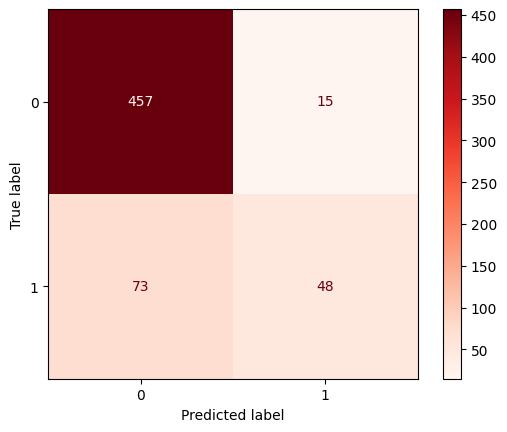

In [50]:
y_pred = pipe_gradient.predict(X_test)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(pipe_gradient, X_test, y_test, cmap='Reds'))

Jika dibandingkan pada random forest tidak ada perbedaan yang signifikan pada classification reportnya. Dapat dilihat bahwa model masih kesusahan dalam memprediksi False Negative (ditunjukkan dengan nilai recall rendah) kemungkinan besar dikarenakan adanya imbalance pada dataset.

Namun tetap saja saya memutuskan bahwa Gradient Boosting memiliki performa terbaik dari keseluruhan model. Oleh karena itu saya akan menggunakan model gradient boosting saja pada hyperparameter tuning untuk melihat apakah ada kenaikan peforma setelah dilakukannya hyperparameter tuning.

## Hyperparameter Tuning

In [51]:
# Membuat hyperparameter
n_estimators = [int(x) for x in np.linspace(start=50, stop=2000, num = 10)]
learning_rate = [float(x) for x in np.linspace(start=0.001, stop=0.1, num = 10)]
max_features = ['sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 1000, 10)]
min_samples_split = [2, 5, 10, 14]
min_samples_leaf = [1, 2, 4, 6, 8]
random_grid = {'n_estimators': n_estimators,
               'learning_rate':learning_rate,
               'max_features':max_features,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'criterion':['friedman_mse','squared_error']}
random_grid

{'n_estimators': [50, 266, 483, 700, 916, 1133, 1350, 1566, 1783, 2000],
 'learning_rate': [0.001,
  0.012,
  0.023000000000000003,
  0.034,
  0.045000000000000005,
  0.05600000000000001,
  0.067,
  0.07800000000000001,
  0.08900000000000001,
  0.1],
 'max_features': ['sqrt', 'log2'],
 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000],
 'min_samples_split': [2, 5, 10, 14],
 'min_samples_leaf': [1, 2, 4, 6, 8],
 'criterion': ['friedman_mse', 'squared_error']}

Pada hyperparameter tuning, saya akan menggunakan RandomSearchCV, alasannya dikarenakan search-space pada hyperparameter yang saya definisikan diatas sangat luas, oleh karena itu jika menggunakan GridSearchCV akan lebih memakan resource dan waktu komputasi yang banyak.

In [52]:
randomcv = RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                                 param_distributions=random_grid,
                                 n_iter=50,
                                 cv=5,
                                 random_state=15,
                                 n_jobs=-1,
                                 scoring='f1')
randomcv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': [0.001, 0.012,
                                                          0.023000000000000003,
                                                          0.034,
                                                          0.045000000000000005,
                                                          0.05600000000000001,
                                                          0.067,
                                                          0.07800000000000001,
                                                          0.08900000000000001,
                                                          0.1],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [50, 266, 483, 700, 916,
                                                         1133, 1350, 1566, 1783,
                                                         2000]},
                   random_state=15, scoring='f1')

In [53]:
# Melihat hyperparameters terbaik
randomcv.best_params_

{'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 450,
 'learning_rate': 0.023000000000000003,
 'criterion': 'squared_error'}

In [54]:
# Mengambil estimator terbaik
randomcv_best = randomcv.best_estimator_
randomcv_best

GradientBoostingClassifier(criterion='squared_error',
                           learning_rate=0.023000000000000003, max_depth=450,
                           max_features='log2', min_samples_leaf=2,
                           min_samples_split=10, n_estimators=2000)

F1 Score - Test Set   :  0.5052631578947367 

Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       472
           1       0.70      0.40      0.51       121

    accuracy                           0.84       593
   macro avg       0.78      0.68      0.71       593
weighted avg       0.83      0.84      0.82       593
 

Confusion Matrix      : 


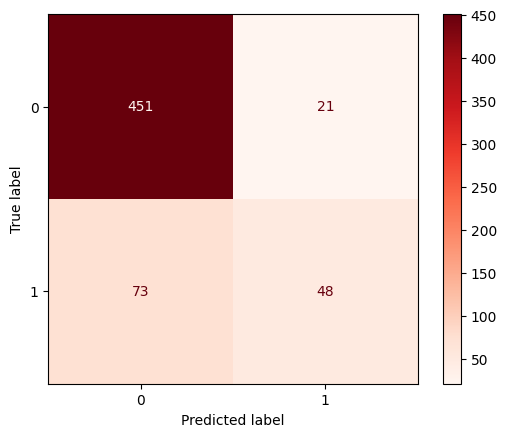

In [55]:
# Melihat peforma model yang sudah di tuning terhadap test-set
y_pred_test = randomcv_best.predict(X_test)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(randomcv_best, X_test, y_test, cmap='Reds'))

Metrik yang cocok digunakan adalah dengan melihat F1 scorenya. Kenapa? karena pada kasus default pada kartu kredit kita tidak bisa menuduh bahwa orang yang sebenarnya tidak default tapi diprediksi oleh model sebagai default. Sama juga kasusnya terhadap jika orang tersebut yang sebenarnya akan default tapi diprediksi tidak default oleh model. Misklasifikasi ini bisa menyebabkan kerugian pada perusahaan bank. jadi kalau pakai F1 score akan memberikan estimasi perkiraan yang lebih baik terhadap keseluruhan kasus misklasifikasi.

Jika dibandingkan pada sebelum dituning tidak ada perbedaan yang signifikan pada classification report dan confusion matrixnya. Dapat dilihat bahwa model masih kesusahan dalam memprediksi False Negative (ditunjukkan dengan nilai recall rendah) dan nilai F1 score yang ikut rendah diakibatkan dari nilai recall yang rendah. 

# 10. Model Saving

In [56]:
# Menggunakan joblib untuk mengexport model
joblib.dump(randomcv_best, 'gradboost_model.pkl')

['gradboost_model.pkl']

# 11. Model Inference

In [57]:
# Menggunakan joblib untuk meload model
pipeline = joblib.load('gradboost_model.pkl')

In [58]:
# Membuat data inference baru
data_inf = {
    'limit': 140000,
    'sex': 1,
    'education': 2,
    'marriage': 1,
    'age': 27,
    'status_sept': -1,
    'status_aug': 1,
    'status_july': -1,
    'status_june': 1,
    'status_may': -1,
    'status_apr': 1,

    'bill_sept': 81233,
    'bill_aug': 3861,
    'bill_july': 3000,
    'bill_june': 7210,
    'bill_may': 15133,
    'bill_apr': 4660,
    
    'pay_sept': 4000,
    'pay_aug': 15128,
    'pay_july': 20182,
    'pay_june': 800,
    'pay_may': 10419,
    'pay_apr': 2019,
}

# Mengubah dictionary ke dataframe
data_inf = pd.DataFrame([data_inf])

# Menampilkan dataframe baru
data_inf

,limit,sex,education,marriage,age,status_sept,status_aug,status_july,status_june,status_may,...,bill_july,bill_june,bill_may,bill_apr,pay_sept,pay_aug,pay_july,pay_june,pay_may,pay_apr
0,140000,1,2,1,27,-1,1,-1,1,-1,...,3000,7210,15133,4660,4000,15128,20182,800,10419,2019


In [59]:
# Melakukan prediksi dengan model dari data baru
prediksi = pipeline.predict(data_inf)
print(prediksi)

[0]


# 12. Conclusion

Berdasarkan hasil evaluasi, saya menemukan bahwa model tersebut mendapatkan skor precision yang cukup tinggi untuk not defaultnya, artinya kemampuan model dalam mengklasifikasikan dengan benar orang yang tidak akan melakukan default. Namun, saya juga melihat bahwa model tersebut memiliki recall yang rendah untuk yang defaultnya, artinya model cenderung melewatkan beberapa kasus default yang sebenarnya.

Hasil ini mengindikasikan bahwa model memiliki kemampuan dalam mengidentifikasi orang yang tidak berisiko default, tapi perlu ditingkatkan dalam mengenali dengan lebih akurat kasus-kasus default. Meskipun model memiliki tingkat akurasi yang baik secara keseluruhan, saya rasa kinerja model dalam mengklasifikasikan kasus default masih belum praktikal untuk digunakan dikehidupan nyata.

## Kelebihan dan Kekurangan Model

Kelebihan:

* precision untuk not default adalah 0.86, yang artinya model bisa memprediksi dengan akurat orang yang tidak akan default, akan menguntungkan perusahaan bank pemilik kartu kredit karena membantu mengidentifikasi orang yang memiliki kemungkinan kecil untuk default, sehingga perusahaan dapat menawarkan program atau hadiah tambahan kepada orang ini untuk mempertahankan mereka.

* recall untuk not default adalah 0.95, yang artinya model bisa dengan baik mengklasifikasikan sebagian besar kasus orang yang tidak akan default. akan menguntungkan perusahaan bank pemilik kartu kredit dalam menghindari perlakuan secara tidak adil orang yang sebenarnya tidak akan default.

Kekurangan:

* precision untuk default adalah 0.68, yang terbilang rendah. Ini menunjukkan bahwa model cenderung memprediksi beberapa kasus sebagai default yang sebenarnya tidak akan melakukan default. bisa mengakibatkan pengurangan pendapatan bagi perusahaan jika tindakan pencegahan diambil untuk orang yang sebenarnya tidak berisiko default.

* recall untuk default adalah 0.41, yang sangat rendah. Ini menunjukkan bahwa model cenderung melewatkan beberapa kasus default yang sebenarnya. Kekurangan ini dapat berpotensi mengakibatkan kerugian bagi perusahaan karena tidak dapat mengidentifikasi dengan tepat orang yang berisiko default.

Jadi meskipun model memiliki tingkat akurasi yang cukup tinggi (0.84), tapi kalau ada kesalahan untuk prediksi default bisa berdampak pada pengambilan keputusan yang diterapkan. Oleh karena itu, sebaiknya kinerja model ditingkatkan dalam mengidentifikasi dengan akurat kasus default untuk mengurangi risiko terkait dengan default pada kartu kredit.

## Improvement?

Hal yang bisa dilakukan untuk meningkatkan kinerja model saya rasa bukan pada model itu sendiri, namun berada pada datasetnya. Saya bisa mengolah data tersebut dengan melakukan oversampling atau undersampling untuk membuat datanya menjadi balance. Dan juga dalam pengumpulan datanya harus ada data yang lebih banyak lagi untuk membuat model menjadi lebih akurat dalam memprediksi.

## Conceptual Problem

> Apa yang dimaksud **criterion?**

Criterion pada Decision Tree adalah sebuah hyperparameter yang berfungsi untuk mengukur kualitas saat pembagian setiap node. Jadi criterion ini berfungsi untuk membantu model dalam menentukan fitur dan kalkulasi terbaik untuk bagaimana pembagian(split) datanya

Pada model Decision Tree diatas, saya gak menentukan secara khusus untuk criterionnya, jadi model Decision Tree diatas menggunakan criterion default yang sudah ditentukan dari scikit-learnnya. yaitu **_gini._**

Gini itu sendiri menghitung kemungkinan terjadinya misklasifikasi pada node. Gini menghitung value antara 0 dan 1, dimana 0 artinya group tersebut benar-benar "pure"(semua prediksi masuk ke kategori yang benar). sedangkan 1 artinya group yang diprediksi salah semua.
Jadi semakin kecil nilai gini, akan semakin akurat prediksi yang dilakukan.


> Apa yang dimaksud **pruning?**

Pruning dalam tree based model, sesuai namanya pruning artinya memangkas atau penyederhanaan cabang-cabang agar tree yang dimiliki tidak terlalu kompleks, jadi fungsi pruning itu untuk meningkatkan kinerja model terhadap unseen data.

Alasan melakukan pruning, adalah untuk mengurangi overfit, meningkatkan generalisasi dan membuat tree yang mudah dipahami dan juga dijelaskan. 

Pruning terbagi 2 yaitu Pre-Pruning dan Post-Pruning.
**Pre-pruning** dilakukan sebelum pembuatan model yaitu untuk menghentikan pohon untuk tumbuh secara keseluruhan. Cara melakukan pre-pruning adalah dengan cara mengatur hyperparameter seperti `max_depth`, `min_samples_leaf`, dan `min_samples_split`. 

Kebalikan dari pre-pruning, pada **Post-Pruning** kita akan membiarkan terlebih dahulu model tree tumbuh secara keseluruhan, setelah itu baru dilakukan pemangkasan pada branch atau cabang-cabang yang ada untuk mencegah overfitting. hyperparameter yang bisa digunakan untuk melakukan post-pruning adalah `ccp_alpha` untuk mencari alpha dengan values terbaik yang menyebabkan best-fit pada model.

> Bagaimana cara memilih **K** pada **KNN**

Tidak ada metode pre-defined untuk menentukan K, Jika value K kecil maka akan sensitif terhadap noise pada data, sedangkan nilai K yang besar akan memakan resource dan waktu komputasi yang besar.

tapi beberapa metode yang saya temukan adalah dengan memilih nilai K secara random diantara angka 3-10 (sebaiknya menggunakan angka ganjil). 

Selain itu ada beberapa metode yang lebih kompleks yaitu square root method, dimana nilai K dihitung berdasarkan akar dari total sample di train-set.
dan ada juga Cross-validation method atau elbow method, biasanya K akan dimulai dari 1 setelah itu akan dilakukan cross validation bisa 5 sampai 10 lipatan, dan setelah itu evaluasi akurasi dari tiap K sampai hasilnya menjadi konsisten. 

> Apa yang dimaksud **cross validation?**

Cross-validation digunakan untuk memberikan estimasi yang lebih realistis pada peforma modelnya terhadap unseen data. Caranya adalah dengan membagi data menjadi beberapa lipatan atau subsets, dan menggunakan salah satu lipatan tersebut sebagai validasi terhadap lipatan lainnya. Setelah itu model akan ditrain terhadap seluruh lipatan yang ada. Proses akan dilakukan berulang-ulang dengan menggunakan lipatan yang berbeda pada setiap validation setnya. Terakhir hasil dari keseluruhan perulangan yang dilakukan akan dirata-rata untuk menunjukkan skor peforma model. 

Beberapa tipe cross-validation adalah K-fold-cross-validation, leave-one-out-cross-validation dan stratified-cross-validation.

> Apa yang dimaksud **Accuracy, Precision, Recall, F1 Score?**

* **Accuracy** menunjukkan rasio prediksi benar dengan keseluruhan data. Accuracy digunakan ketika target yang ada pada dataset mempunyai distribusi yang normal / setara dan Accuracy akan memberikan hasil yang tidak akurat ketika data yang dimiliki termasuk imbalance

* **Precision** menunjukkan perbandingan antara True positive dibandingkan dengan banyaknya data yang diprediksi positive. Precision digunakan ketika kita ingin fokus dalam mengurangi jumlah hasil false positive 

* **Recall** menunjukkan perbandingan antara True Positive dibandingkan dengan banyaknya data yang sebenarnya positive. Recall digunakan ketika kita ingin fokus dalam mengurangi hasil false negative 

* **F1 Score** adalah "Harmonic Mean" dari precision dan recall, atau bisa dibilang F1 adalah metrik yang berada di titik tengah antara precision dan recall. F1 Score digunakan ketika target memiliki data yang imbalance F1 score bisa memberikan hasil yang lebih realistis terhadap peforma keseluruhan model dibandingkan metriks Accuracy.
